<a href="https://colab.research.google.com/github/hurshd0/DS-Unit-2-Regression-Classification/blob/master/module3/lesson_regression_classification_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Lambda School Data Science, Unit 2: Predictive Modeling

# Regression & Classification, Module 3

### Setup

#### If you're using [Anaconda](https://www.anaconda.com/distribution/) locally

Install required Python packages, if you haven't already:
- [category_encoders](http://contrib.scikit-learn.org/categorical-encoding/), version >= 2.0
- [Plotly](https://plot.ly/python/getting-started/), version >= 4.0

```
conda install -c conda-forge category_encoders plotly
```

In [1]:
# If you're in Colab...
import os, sys
in_colab = 'google.colab' in sys.modules

if in_colab:
    # Install required python packages:
    # category_encoders, version >= 2.0
    # pandas-profiling, version >= 2.0
    # plotly, version >= 4.0
    !pip install --upgrade category_encoders pandas-profiling plotly
    
    # Pull files from Github repo
    os.chdir('/content')
    !git init .
    !git remote add origin https://github.com/hurshd0/DS-Unit-2-Regression-Classification.git
    !git pull origin master
    
    # Change into directory for module
    os.chdir('module3')

  Using cached https://files.pythonhosted.org/packages/6e/a1/f7a22f144f33be78afeb06bfa78478e8284a64263a3c09b1ef54e673841e/category_encoders-2.0.0-py2.py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/2c/2f/aae19e2173c10a9bb7fee5f5cad35dbe53a393960fc91abc477dcc4661e8/pandas-profiling-2.3.0.tar.gz
  Using cached https://files.pythonhosted.org/packages/63/2b/4ca10995bfbdefd65c4238f9a2d3fde33705d18dd50914dd13302ec1daf1/plotly-4.1.0-py2.py3-none-any.whl
     |████████████████████████████████| 614kB 4.3MB/s 
     |████████████████████████████████| 225kB 39.6MB/s 
     |████████████████████████████████| 768kB 40.6MB/s 
     |████████████████████████████████| 51kB 16.6MB/s 
     |████████████████████████████████| 194kB 42.2MB/s 
     |████████████████████████████████| 737kB 41.2MB/s 
     |████████████████████████████████| 51kB 15.4MB/s 
  Created wheel for pandas-profiling: filename=pandas_profiling-2.3.0-py2.py3-none-any.whl size=145036 sha256=27dd6835e30c07b9d66aa20ad2

In [0]:
# Ignore this Numpy warning when using Plotly Express:
# FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
import warnings
warnings.filterwarnings(action='ignore', category=FutureWarning, module='numpy')

# Let's start with example solutions for yesterday's assignment!

First, load data & remove outliers:

In [0]:
import numpy as np
import pandas as pd

# Read New York City apartment rental listing data
df = pd.read_csv('../data/renthop-nyc.csv')
assert df.shape == (49352, 34)

# Remove the most extreme 1% prices,
# the most extreme .1% latitudes, &
# the most extreme .1% longitudes
df = df[(df['price'] >= np.percentile(df['price'], 0.5)) & 
        (df['price'] <= np.percentile(df['price'], 99.5)) & 
        (df['latitude'] >= np.percentile(df['latitude'], 0.05)) & 
        (df['latitude'] < np.percentile(df['latitude'], 99.95)) &
        (df['longitude'] >= np.percentile(df['longitude'], 0.05)) & 
        (df['longitude'] <= np.percentile(df['longitude'], 99.95))]

## Do train/test split
- Use data from April & May 2016 to train
- Use data from June 2016 to test

In [4]:
# Convert to datetime and look at the date range
df['created'] = pd.to_datetime(df['created'], infer_datetime_format=True)
df['created'].describe()

count                   48817
unique                  48148
top       2016-05-14 01:11:03
freq                        3
first     2016-04-01 22:12:41
last      2016-06-29 21:41:47
Name: created, dtype: object

In [5]:
# There are 16217 + 15627 observations in April & May 2016,
# and 16973 observations in June 2016.
df['created'].dt.month.value_counts()

6    16973
4    16217
5    15627
Name: created, dtype: int64

In [6]:
# There are many ways to do train/test split based on date.
# Here's one way:
train = df[df.created.dt.month < 6]
test  = df[df.created.dt.month == 6]
train.shape, test.shape

((31844, 34), (16973, 34))

In [7]:
# Here's another way
cutoff = pd.to_datetime('2016-06-01')
train = df[df.created < cutoff]
test  = df[df.created >= cutoff]
train.shape, test.shape

((31844, 34), (16973, 34))

In [8]:
# Here's another way
df = df.set_index('created')
train = df[:'2016-05'].reset_index()
test  = df['2016-06':].reset_index()
df = df.reset_index()
train.shape, test.shape

((31844, 34), (16973, 34))

## Location, Location, Location?

In [9]:
# Look at relationship between location & price
import plotly.express as px
px.scatter(train, x='longitude', y='latitude', color='price')

In [10]:
# Cluster the locations
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=10)
train['cluster'] = kmeans.fit_predict(train[['longitude', 'latitude']])
test['cluster'] = kmeans.predict(test[['longitude', 'latitude']])
px.scatter(train, x='longitude', y='latitude', color='cluster')

In [18]:
train.groupby('bedrooms').price.mean()

bedrooms
0    2480.870706
1    3057.281467
2    3787.781992
3    4974.523553
4    5922.475355
5    8177.637681
6    8228.863636
7    6923.000000
Name: price, dtype: float64

In [19]:
train.groupby('cluster').price.describe()

,count,mean,std,min,25%,50%,75%,max
cluster,,,,,,,,
0,5986.0,3398.511193,2040.947822,1400.0,2200.0,2795.0,3695.0,15000.0
1,3364.0,3931.534483,1692.508585,1450.0,2850.0,3450.0,4450.0,15000.0
2,4926.0,3746.933821,1518.224880,1550.0,2730.0,3350.0,4395.0,15000.0
3,2558.0,3656.523847,1953.386245,1395.0,2500.0,3100.0,4050.0,15500.0
4,1430.0,2770.948252,939.594063,1375.0,2196.0,2600.0,3147.0,14500.0
5,525.0,2038.266667,512.760734,1375.0,1695.0,1900.0,2250.0,4350.0
6,4826.0,3737.305429,1750.325888,1450.0,2695.0,3290.0,4200.0,15500.0
7,1448.0,2216.524171,662.385756,1375.0,1700.0,2000.0,2525.0,5000.0
8,6060.0,4048.776073,1707.776753,1500.0,2895.0,3625.0,4750.0,15500.0


## Exploratory visualization for predictive modeling

Visualize the relationships between feature(s) and target.

_Recommendations:_

Do this with your training set, after splitting your data. 

Try [Seaborn "Categorical estimate" plots](https://seaborn.pydata.org/tutorial/categorical.html) for features with reasonably few unique values. (With too many unique values, the plot is unreadable.)

- Categorical features. (If there are too many unique values, you can replace less frequent values with "OTHER.")
- Numeric features. (If there are too many unique values, you can [bin with pandas cut / qcut functions](https://pandas.pydata.org/pandas-docs/stable/getting_started/basics.html?highlight=qcut#discretization-and-quantiling).)

Try [Seaborn linear model plots](https://seaborn.pydata.org/tutorial/regression.html) with numeric features. 

Seaborn is nice because it includes confidence intervals to visualize uncertainty.

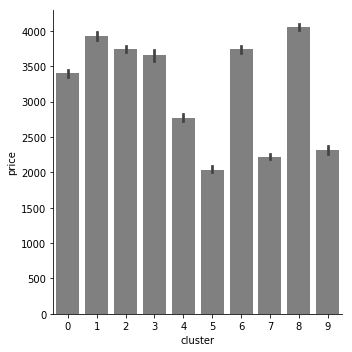

In [20]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.catplot(x='cluster', y='price', data=train, kind='bar', color='grey');

/usr/local/lib/python3.6/dist-packages/matplotlib/pyplot.py:514: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).



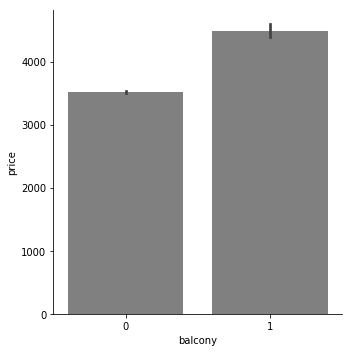

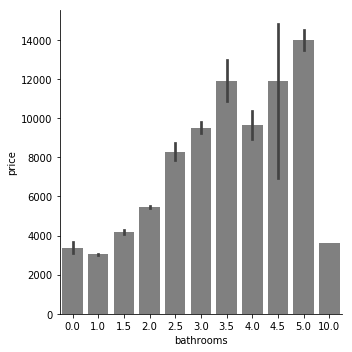

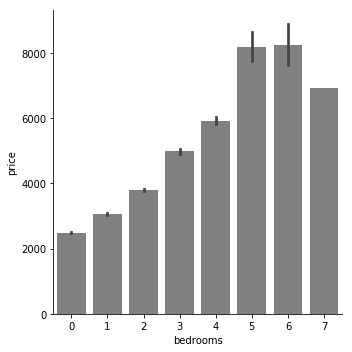

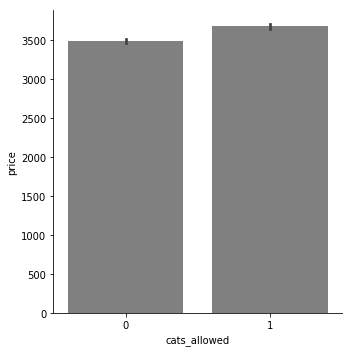

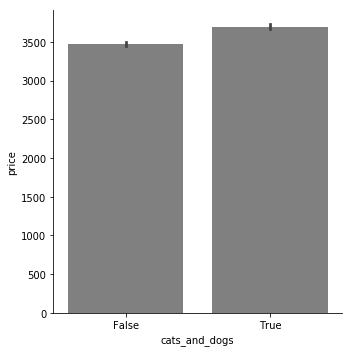

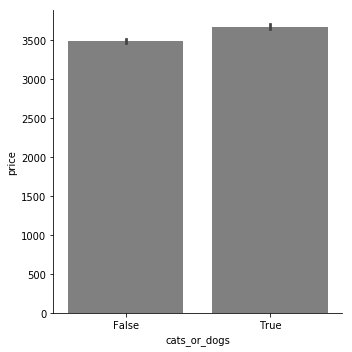

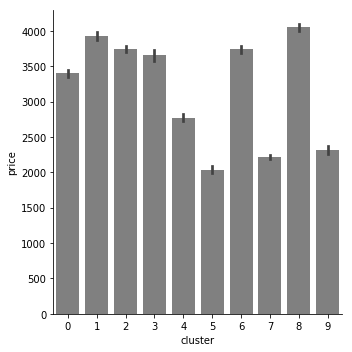

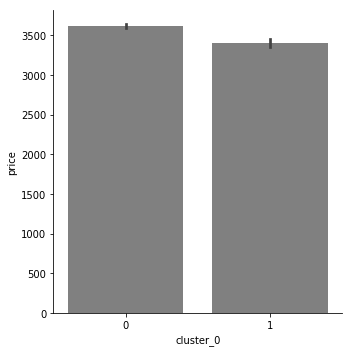

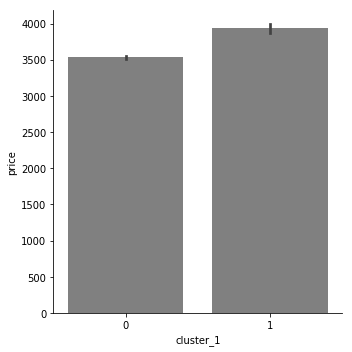

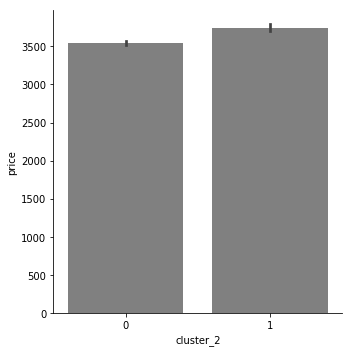

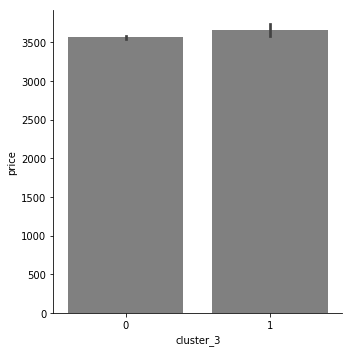

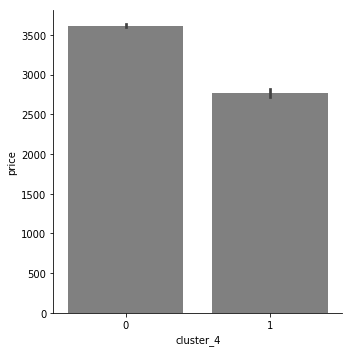

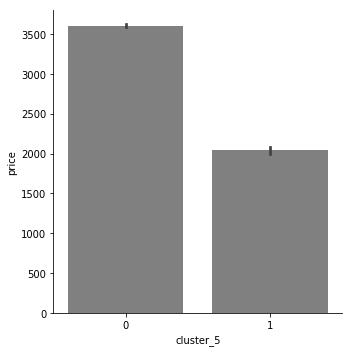

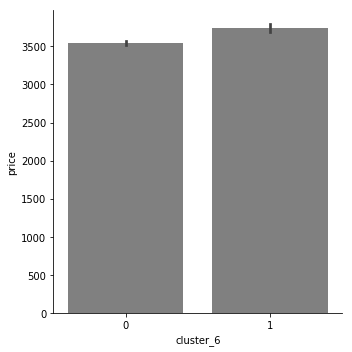

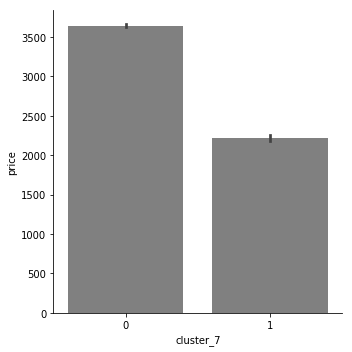

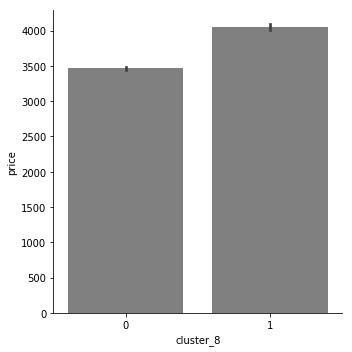

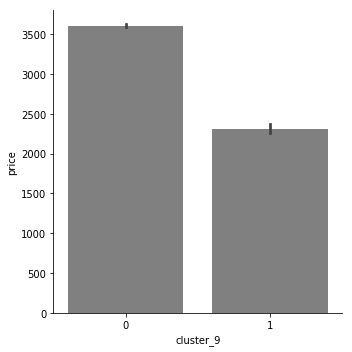

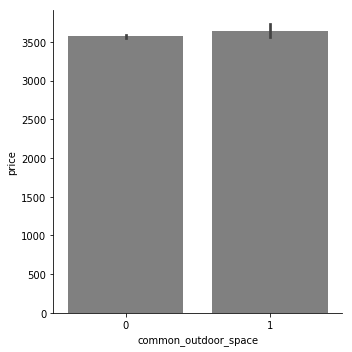

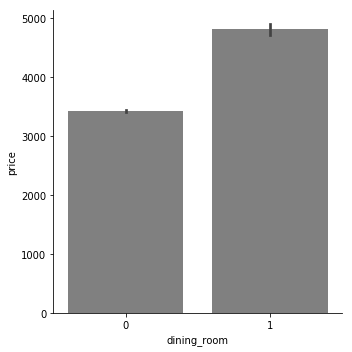

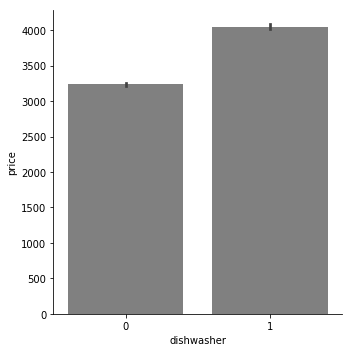

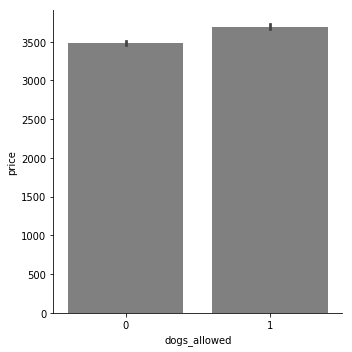

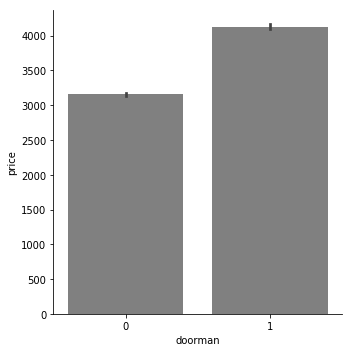

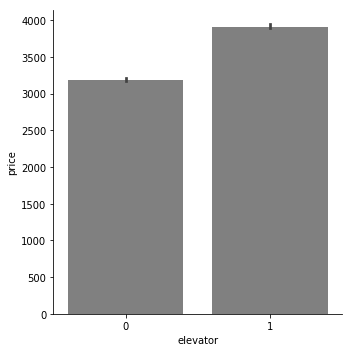

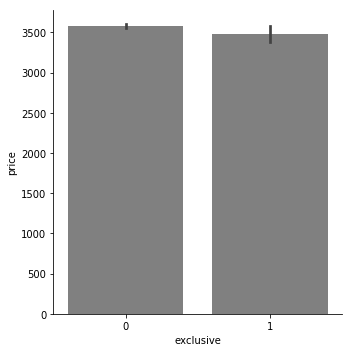

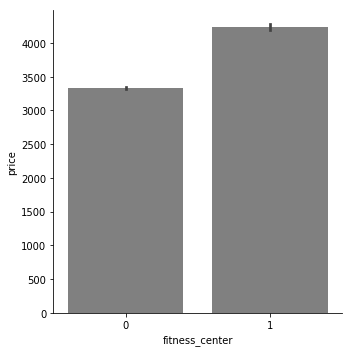

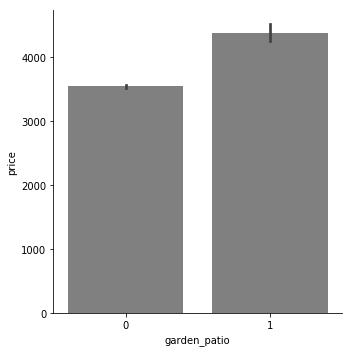

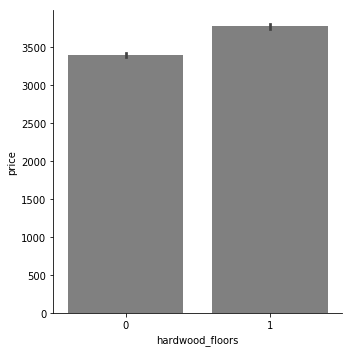

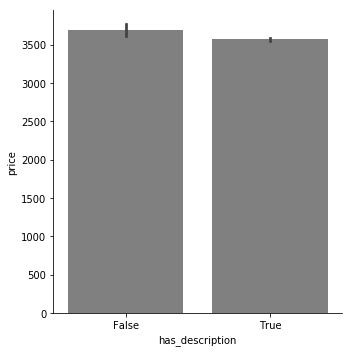

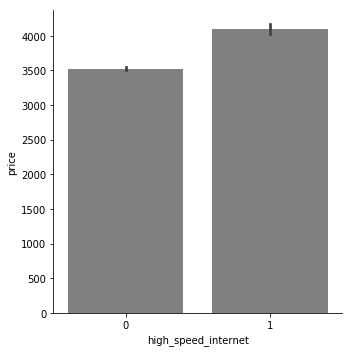

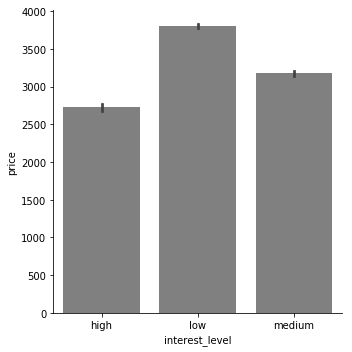

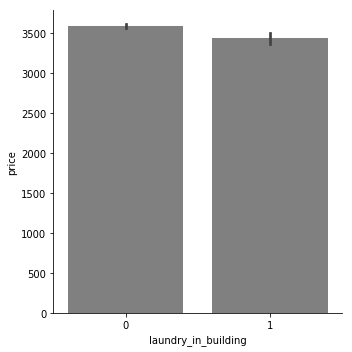

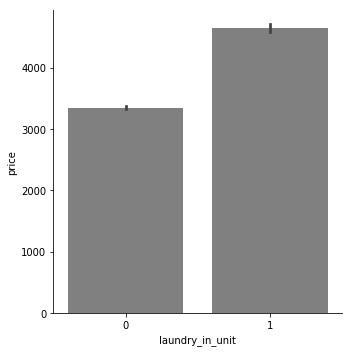

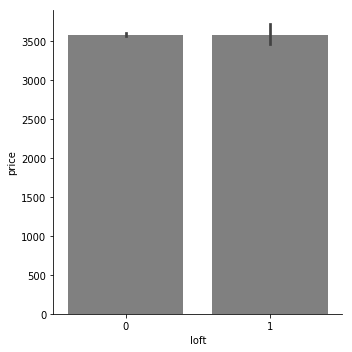

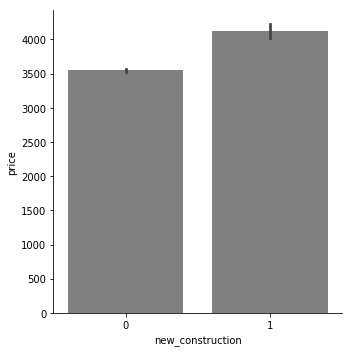

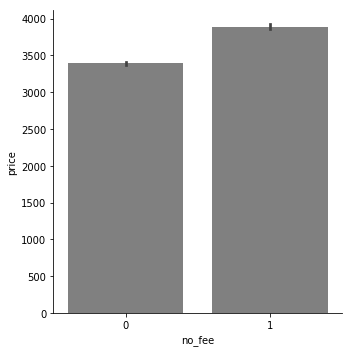

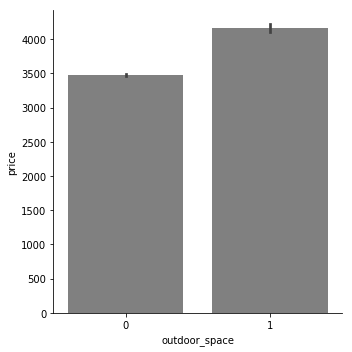

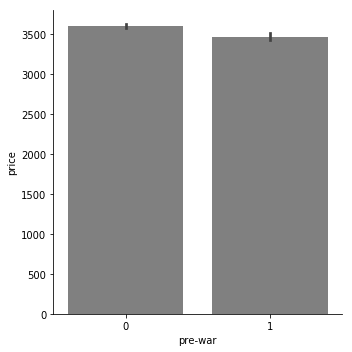

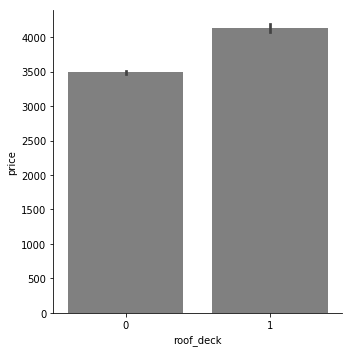

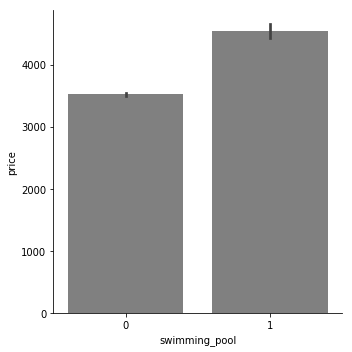

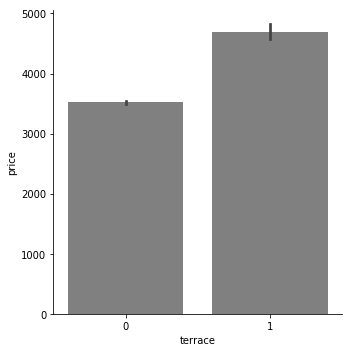

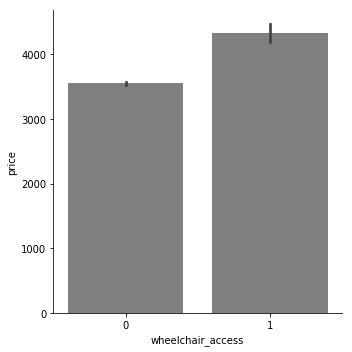

In [22]:
for col in sorted(train.columns):
    if train[col].nunique() < 12:
        sns.catplot(x=col, y='price', data=train, kind='bar', color='grey')

/usr/local/lib/python3.6/dist-packages/matplotlib/pyplot.py:514: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).



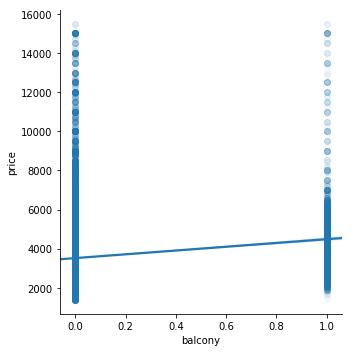

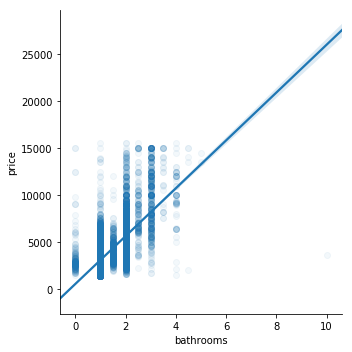

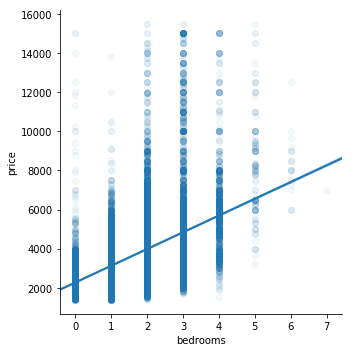

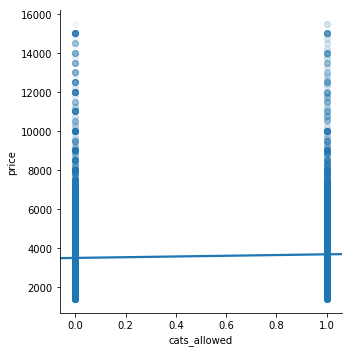

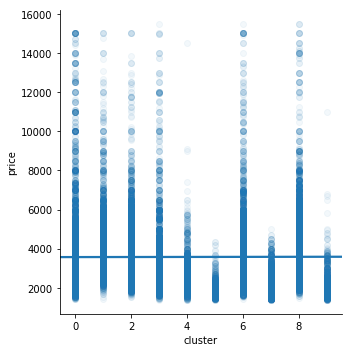

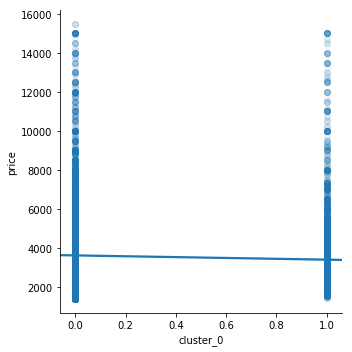

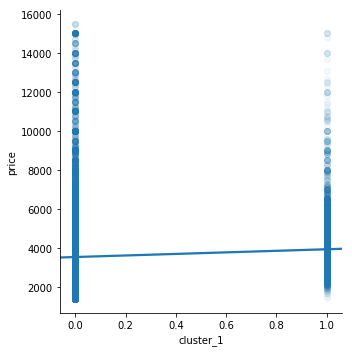

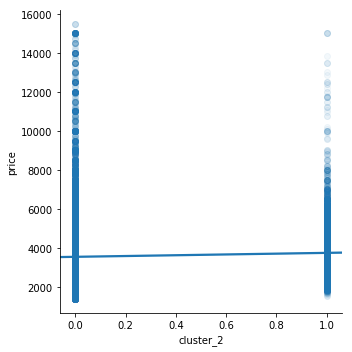

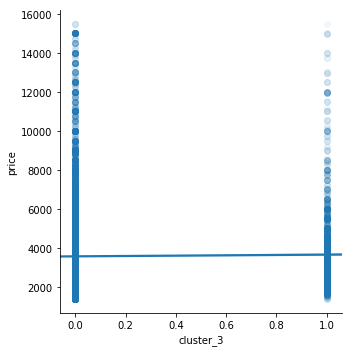

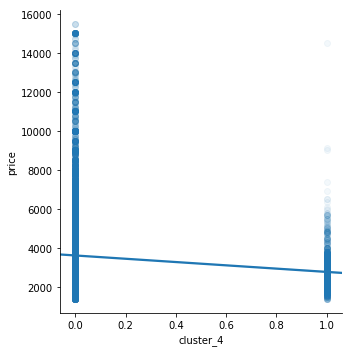

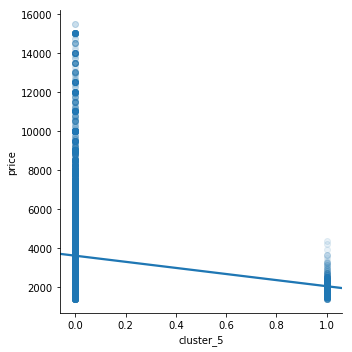

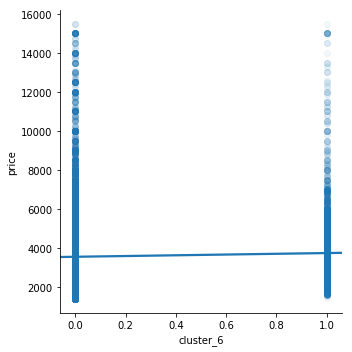

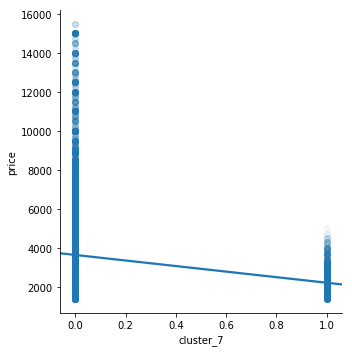

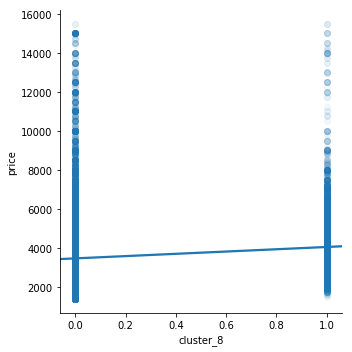

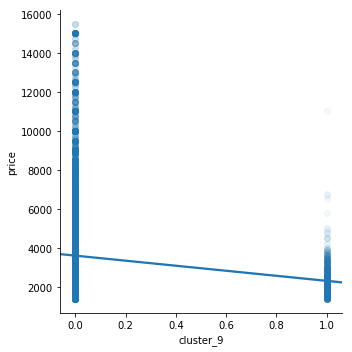

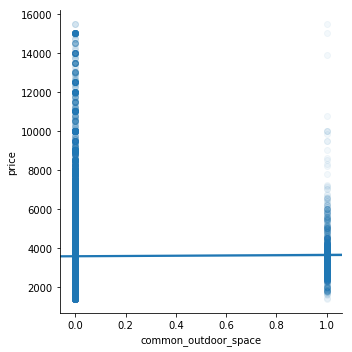

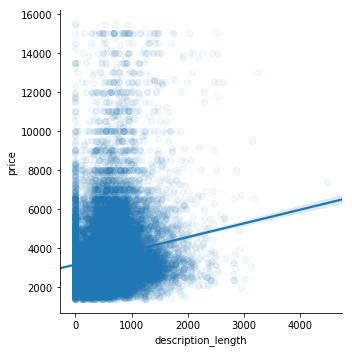

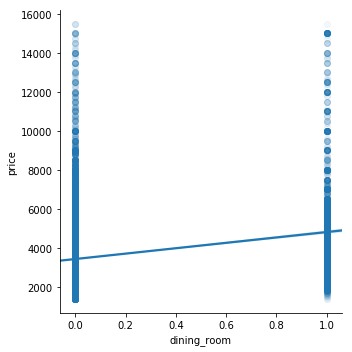

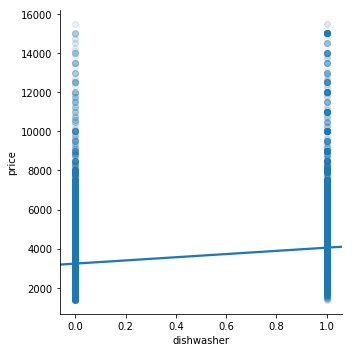

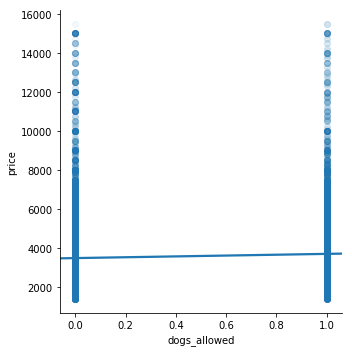

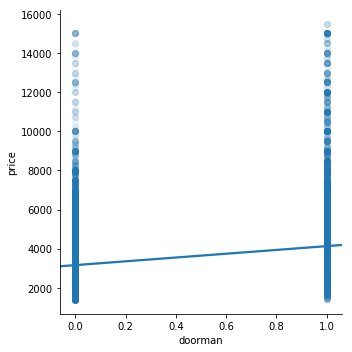

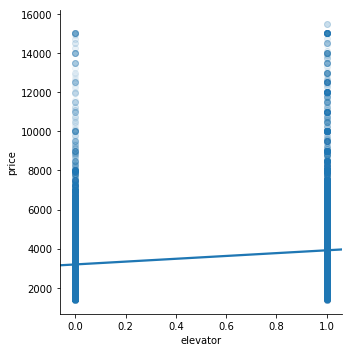

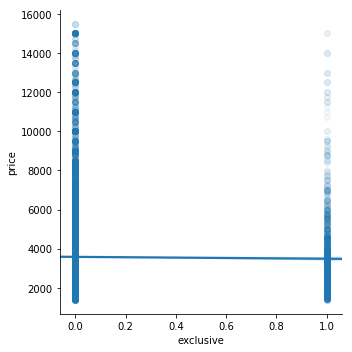

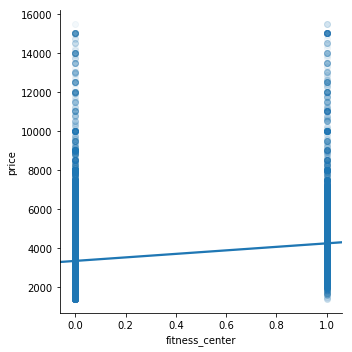

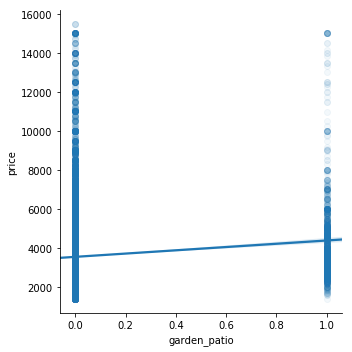

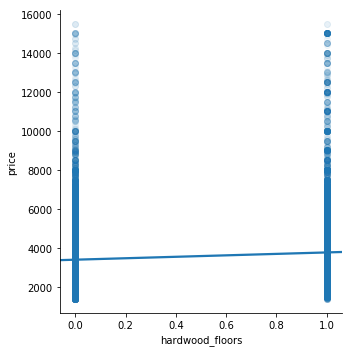

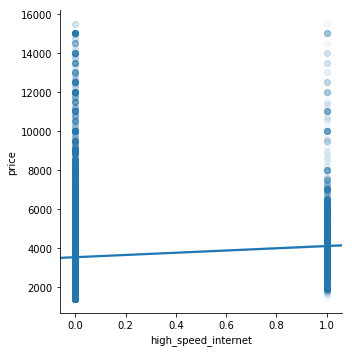

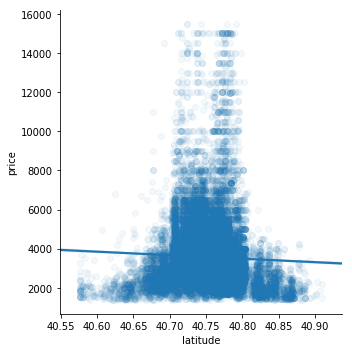

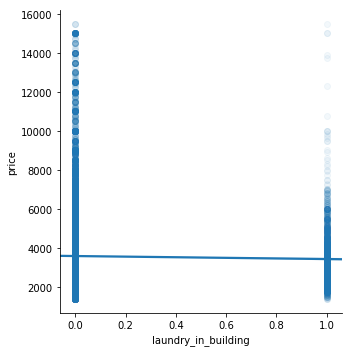

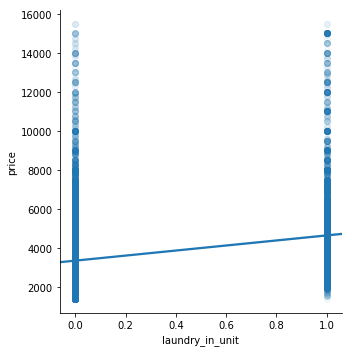

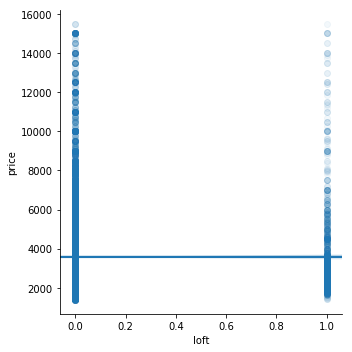

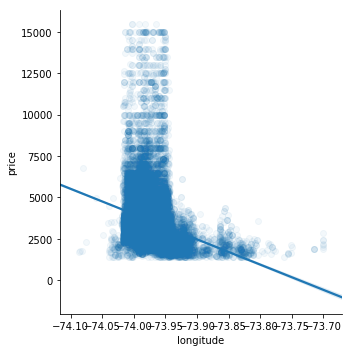

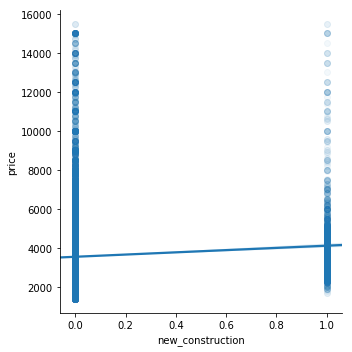

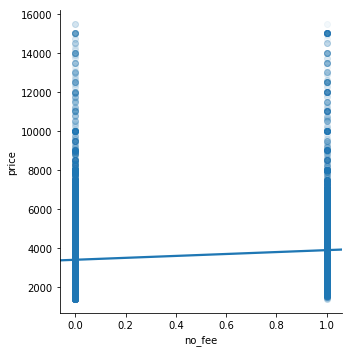

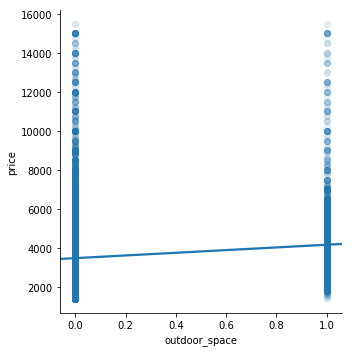

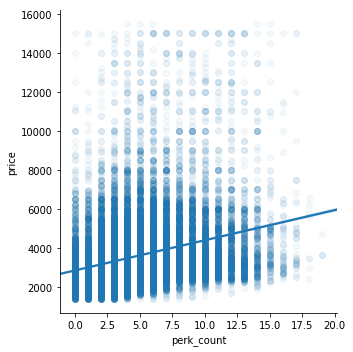

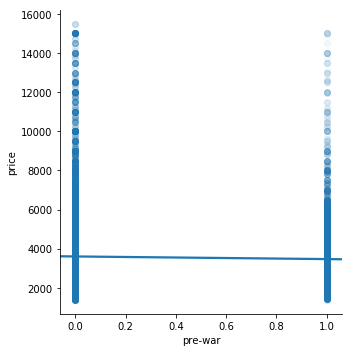

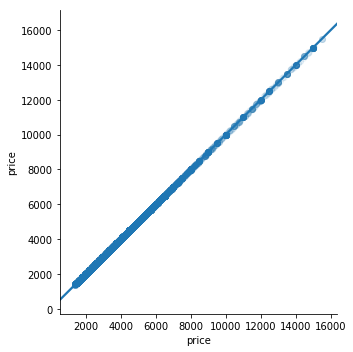

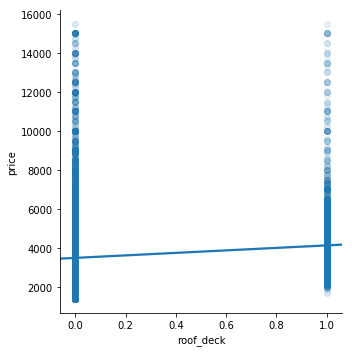

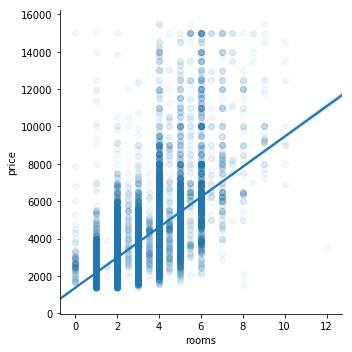

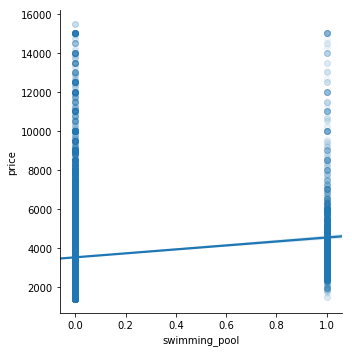

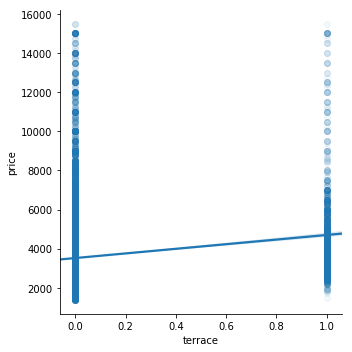

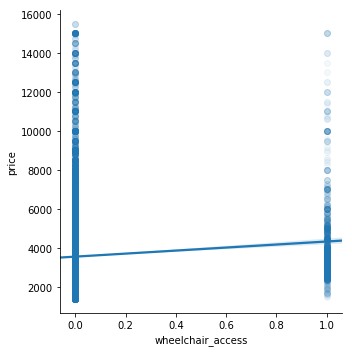

In [23]:
numeric = train.select_dtypes('number')
for col in sorted(numeric.columns):
    sns.lmplot(x=col, y='price', data=train, scatter_kws=dict(alpha=0.05))

## Feature Engineering

In [24]:
def engineer_features(df):
    # What's the neighborhood, based on address or latitude & longitude?
    clusters = pd.get_dummies(df['cluster'], prefix='cluster')
    for col in clusters:
        df[col] = clusters[col]
        
    # Does the apartment have a description?
    df['description'] = df['description'].str.strip().fillna('')
    df['has_description'] = df['description'] != ''

    # How long is the description?
    df['description_length'] = df['description'].str.len()

    # How many total perks does each apartment have?
    perk_cols = ['elevator', 'cats_allowed', 'hardwood_floors', 'dogs_allowed',
                 'doorman', 'dishwasher', 'no_fee', 'laundry_in_building',
                 'fitness_center', 'pre-war', 'laundry_in_unit', 'roof_deck',
                 'outdoor_space', 'dining_room', 'high_speed_internet', 'balcony',
                 'swimming_pool', 'new_construction', 'exclusive', 'terrace', 
                 'loft', 'garden_patio', 'common_outdoor_space', 
                 'wheelchair_access']
    df['perk_count'] = df[perk_cols].sum(axis=1)

    # Are cats or dogs allowed?
    df['cats_or_dogs'] = (df['cats_allowed']==1) | (df['dogs_allowed']==1)

    # Are cats and dogs allowed?
    df['cats_and_dogs'] = (df['cats_allowed']==1) & (df['dogs_allowed']==1)

    # Total number of rooms (beds + baths)
    df['rooms'] = df['bedrooms'] + df['bathrooms']

    return df

    
train = engineer_features(train)
test = engineer_features(test)
train.shape, test.shape

((31844, 51), (16973, 51))

## Feature Selection

The previous assignment quoted Wikipedia on [Feature Engineering](https://en.wikipedia.org/wiki/Feature_engineering):

> "Some machine learning projects succeed and some fail. What makes the difference? Easily the most important factor is the features used." — Pedro Domingos, ["A Few Useful Things to Know about Machine Learning"](https://homes.cs.washington.edu/~pedrod/papers/cacm12.pdf)

> "Coming up with features is difficult, time-consuming, requires expert knowledge. 'Applied machine learning' is basically feature engineering." — Andrew Ng, [Machine Learning and AI via Brain simulations](https://forum.stanford.edu/events/2011/2011slides/plenary/2011plenaryNg.pdf) 

> Feature engineering is the process of using domain knowledge of the data to create features that make machine learning algorithms work. 

Pedro Domingos says, "the most important factor is the **features used**."

This includes not just **Feature Engineering** (making new features, representing features in new ways) but also **Feature Selection** (choosing which features to include and which to exclude).

There are _many_ specific tools and techniques for feature selection.

- Today we'll try [scikit-learn's `SelectKBest` transformer](https://scikit-learn.org/stable/modules/feature_selection.html#univariate-feature-selection), for "univariate, forward selection."
- Next week we'll try another technique, ["permutation importance"](https://www.kaggle.com/dansbecker/permutation-importance)
- If you want to explore even more options, here are some good resources!
  - [scikit-learn's User Guide for Feature Selection](https://scikit-learn.org/stable/modules/feature_selection.html)
  - [mlxtend](http://rasbt.github.io/mlxtend/) library
  - scikit-learn-contrib libraries: [boruta_py](https://github.com/scikit-learn-contrib/boruta_py) & [stability-selection](https://github.com/scikit-learn-contrib/stability-selection)
  - [_Feature Engineering and Selection_](http://www.feat.engineering/) by Kuhn & Johnson.


My general recommendation is:

> Predictive accuracy on test sets is the criterion for how good the model is. — Leo Breiman, ["Statistical Modeling: The Two Cultures"](https://projecteuclid.org/download/pdf_1/euclid.ss/1009213726)

### Can we try every possible feature combination?
- https://en.wikipedia.org/wiki/Combination
- https://docs.python.org/3/library/itertools.html#itertools.combinations
- https://docs.python.org/3/library/math.html#math.factorial

In [25]:
# How many features do we have currently?
target = 'price'
features = train.columns.drop(target)
len(features)

50

In [30]:
features

Index(['created', 'bathrooms', 'bedrooms', 'description', 'display_address',
       'latitude', 'longitude', 'street_address', 'interest_level', 'elevator',
       'cats_allowed', 'hardwood_floors', 'dogs_allowed', 'doorman',
       'dishwasher', 'no_fee', 'laundry_in_building', 'fitness_center',
       'pre-war', 'laundry_in_unit', 'roof_deck', 'outdoor_space',
       'dining_room', 'high_speed_internet', 'balcony', 'swimming_pool',
       'new_construction', 'terrace', 'exclusive', 'loft', 'garden_patio',
       'wheelchair_access', 'common_outdoor_space', 'cluster', 'cluster_0',
       'cluster_1', 'cluster_2', 'cluster_3', 'cluster_4', 'cluster_5',
       'cluster_6', 'cluster_7', 'cluster_8', 'cluster_9', 'has_description',
       'description_length', 'perk_count', 'cats_or_dogs', 'cats_and_dogs',
       'rooms'],
      dtype='object')

In [26]:
# How many ways to choose 1 feature?
from itertools import combinations
len(list(combinations(features, 1)))

50

In [27]:
# How many ways to choose 2 features?
len(list(combinations(features, 2)))

1225

In [28]:
# How many ways to choose 3 features?
len(list(combinations(features, 3)))

19600

In [29]:
# How many ways to choose 1 to n features?
from math import factorial

def n_choose_k(n, k):
    return factorial(n)/(factorial(k)*factorial(n-k))

total = 0
for k in range(1, len(features)+1):
    total += n_choose_k(len(features), k)
    
print(f'{total:,}')

1,125,899,906,842,623.0


### Start simple & fast, with a subset of columns

Just numeric columns with no missing values

In [31]:
train_subset = train.select_dtypes('number').dropna(axis='columns')
test_subset  = test.select_dtypes('number').dropna(axis='columns')
assert all(train_subset.columns == test_subset.columns)

target = 'price'
features = train_subset.columns.drop(target)
X_train = train_subset[features]
y_train = train_subset[target]
X_test  = test_subset[features]
y_test  = test_subset[target]
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((31844, 42), (31844,), (16973, 42), (16973,))

### Univariate, Forward selection
https://scikit-learn.org/stable/modules/feature_selection.html#univariate-feature-selection

In [33]:
# Select the 10 features that best correlate with the target
from sklearn.feature_selection import f_regression, SelectKBest

# Similar API to what we've seen before:
# model = LinearRegression()
# model.fit(...)

# IMPORTANT!
# .fit_transform on the train set
# .transform on test set

selector = SelectKBest(score_func=f_regression, k=10)
X_train_selected = selector.fit_transform(X_train, y_train)
X_test_selected = selector.transform(X_test)

X_train_selected.shape, X_test_selected.shape

((31844, 10), (16973, 10))

In [34]:
# Which features were selected?
all_names = X_train.columns
selected_mask = selector.get_support()
selected_names = all_names[selected_mask]
unselected_names = all_names[~selected_mask]

print('Features selected:')
for name in selected_names:
    print(name)

print('\nFeatures not selected:')
for name in unselected_names:
    print(name)

Features selected:
bathrooms
bedrooms
longitude
doorman
dishwasher
fitness_center
laundry_in_unit
dining_room
perk_count
rooms

Features not selected:
latitude
elevator
cats_allowed
hardwood_floors
dogs_allowed
no_fee
laundry_in_building
pre-war
roof_deck
outdoor_space
high_speed_internet
balcony
swimming_pool
new_construction
terrace
exclusive
loft
garden_patio
wheelchair_access
common_outdoor_space
cluster
cluster_0
cluster_1
cluster_2
cluster_3
cluster_4
cluster_5
cluster_6
cluster_7
cluster_8
cluster_9
description_length


In [36]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error

model = LinearRegression()
model.fit(X_train_selected, y_train)
y_pred = model.predict(X_test_selected)
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r_square = model.score(X_test_selected, y_test)
print('''
R^2: {:.2f}
MSE: {:.2f}
RMSE: {:.2f}
MAE: ${:.2f}
'''.format(r_square, mse, rmse, mae))


R^2: 0.61
MSE: 1208001.18
RMSE: 1099.09
MAE: $712.93



In [38]:
for k in range(1, len(X_train.columns)+1):
    print(f'{k} features')
    
    selector = SelectKBest(score_func=f_regression, k=k)
    X_train_selected = selector.fit_transform(X_train, y_train)
    X_test_selected = selector.transform(X_test)
    
    model = LinearRegression()
    model.fit(X_train_selected, y_train)
    y_pred = model.predict(X_test_selected)
    
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r_square = model.score(X_test_selected, y_test)
    print('''
    R^2: {:.2f}
    MSE: {:.2f}
    RMSE: {:.2f}
    MAE: ${:.2f}
    '''.format(r_square, mse, rmse, mae))

1 features

    R^2: 0.48
    MSE: 1615207.84
    RMSE: 1270.91
    MAE: $890.46
    
2 features

    R^2: 0.52
    MSE: 1487715.31
    RMSE: 1219.72
    MAE: $825.90
    
3 features

    R^2: 0.52
    MSE: 1487828.95
    RMSE: 1219.77
    MAE: $825.87
    
4 features

    R^2: 0.54
    MSE: 1421221.41
    RMSE: 1192.15
    MAE: $799.73
    
5 features

    R^2: 0.54
    MSE: 1416535.17
    RMSE: 1190.18
    MAE: $800.16
    
6 features

    R^2: 0.57
    MSE: 1339992.18
    RMSE: 1157.58
    MAE: $772.66
    
7 features

    R^2: 0.61
    MSE: 1214342.57
    RMSE: 1101.97
    MAE: $713.08
    
8 features

    R^2: 0.61
    MSE: 1209468.67
    RMSE: 1099.76
    MAE: $713.46
    
9 features

    R^2: 0.61
    MSE: 1209342.82
    RMSE: 1099.70
    MAE: $713.45
    
10 features

    R^2: 0.61
    MSE: 1208001.18
    RMSE: 1099.09
    MAE: $712.93
    
11 features

    R^2: 0.61
    MSE: 1205669.31
    RMSE: 1098.03
    MAE: $710.80
    
12 features

    R^2: 0.62
    MSE: 1187890.01
    R

## Do one-hot encoding of categorical features

### Which features are non-numeric?

In [39]:
train.describe(exclude='number')

,created,description,display_address,street_address,interest_level,has_description,cats_or_dogs,cats_and_dogs
count,31844,31844,31775,31838,31844,31844,31844,31844
unique,31436,25710,6468,11280,3,2,2,2
top,2016-05-14 01:11:03,,Broadway,505 West 37th Street,low,True,False,False
freq,3,2033,273,120,22053,29811,16627,17669
first,2016-04-01 22:12:41,NaN,NaN,NaN,NaN,NaN,NaN,NaN
last,2016-05-31 23:10:48,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [0]:
binary_columns = ['has_description', 'cats_or_dogs', 'cats_and_dogs']
for col in binary_columns:
    train[col] = train[col].astype(int)
    test[col] = test[col].astype(int)

In [41]:
train[binary_columns].describe()

,has_description,cats_or_dogs,cats_and_dogs
count,31844.000000,31844.000000,31844.000000
mean,0.936158,0.477861,0.445139
std,0.244476,0.499517,0.496989
min,0.000000,0.000000,0.000000
25%,1.000000,0.000000,0.000000
50%,1.000000,0.000000,0.000000
75%,1.000000,1.000000,1.000000
max,1.000000,1.000000,1.000000


### Check "cardinality" of non-numeric features

[Cardinality](https://simple.wikipedia.org/wiki/Cardinality) means the number of unique values that a feature has:
> In mathematics, the cardinality of a set means the number of its elements. For example, the set A = {2, 4, 6} contains 3 elements, and therefore A has a cardinality of 3. 

"One-hot encoding" adds a dimension for each unique value of each categorical feature. So, it may not be a good choice for "high cardinality" categoricals that have dozens, hundreds, or thousands of unique values. 

In [42]:
train.describe(exclude='number').T.sort_values(by='unique')

,count,unique,top,freq,first,last
interest_level,31844,3,low,22053,NaN,NaN
display_address,31775,6468,Broadway,273,NaN,NaN
street_address,31838,11280,505 West 37th Street,120,NaN,NaN
description,31844,25710,,2033,NaN,NaN
created,31844,31436,2016-05-14 01:11:03,3,2016-04-01 22:12:41,2016-05-31 23:10:48


In [43]:
df['display_address'].value_counts()

Broadway                                                   435
East 34th Street                                           355
Second Avenue                                              349
Wall Street                                                330
West 37th Street                                           287
West Street                                                257
First Avenue                                               244
Gold Street                                                241
York Avenue                                                228
Washington Street                                          227
Water Street                                               214
John Street                                                214
East 39th Street                                           198
East 89th Street                                           195
West 54th Street                                           193
Lexington Avenue                                       

### Explore `interest_level` feature

In [44]:
train['interest_level'].value_counts(normalize=True)

low       0.692532
medium    0.231786
high      0.075681
Name: interest_level, dtype: float64

In [45]:
train.groupby('interest_level')['price'].mean()

interest_level
high      2728.689212
low       3802.227633
medium    3175.026013
Name: price, dtype: float64

In [46]:
# Look at interest level for first 5 apartments
train['interest_level'].head()

0      high
1       low
2       low
3    medium
4       low
Name: interest_level, dtype: object

### Encode `interest_level` feature

In [47]:
# Look at interest level for first 5 apartments, one-hot
import category_encoders as ce
encoder = ce.OneHotEncoder(use_cat_names=True)
encoded = encoder.fit_transform(train['interest_level'])
encoded.head()

,interest_level_high,interest_level_low,interest_level_medium
0,1,0,0
1,0,1,0
2,0,1,0
3,0,0,1
4,0,1,0


## Do one-hot encoding & Scale features, 
within a complete model fitting workflow.

### Why and how to scale features before fitting linear models

Scikit-Learn User Guide, [Preprocessing data](https://scikit-learn.org/stable/modules/preprocessing.html)
> Standardization of datasets is a common requirement for many machine learning estimators implemented in scikit-learn; they might behave badly if the individual features do not more or less look like standard normally distributed data: Gaussian with zero mean and unit variance.

> The `preprocessing` module further provides a utility class `StandardScaler` that implements the `Transformer` API to compute the mean and standard deviation on a training set. The scaler instance can then be used on new data to transform it the same way it did on the training set.

### How to use encoders and scalers in scikit-learn
- Use the **`fit_transform`** method on the **train** set
- Use the **`transform`** method on the **validation / test** sets

In [48]:
from sklearn.preprocessing import StandardScaler

target = 'price'
high_cardinality = ['display_address', 'street_address', 'description', 'created']
features = train.columns.drop([target] + high_cardinality)

X_train = train[features]
y_train = train[target]

X_test = test[features]
y_test = test[target]

encoder = ce.OneHotEncoder(use_cat_names=True)
X_train_encoded = encoder.fit_transform(X_train)
X_test_encoded = encoder.transform(X_test)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_encoded)
X_test_scaled = scaler.transform(X_test_encoded)

for k in range(1, len(X_train.columns)+1):
    print(f'{k} features')
    
    selector = SelectKBest(score_func=f_regression, k=k)
    X_train_selected = selector.fit_transform(X_train_scaled, y_train)
    X_test_selected = selector.transform(X_test_scaled)
    
    model = LinearRegression()
    model.fit(X_train_selected, y_train)
    
    y_pred = model.predict(X_test_selected)
    mae = mean_absolute_error(y_test, y_pred)
    print(f'Test MAE: ${mae:,.0f} \n')

1 features
Test MAE: $890 

2 features
Test MAE: $826 

3 features
Test MAE: $826 

4 features
Test MAE: $800 

5 features
Test MAE: $800 

6 features
Test MAE: $773 

7 features
Test MAE: $713 

8 features
Test MAE: $714 

9 features
Test MAE: $714 

10 features
Test MAE: $713 

11 features
Test MAE: $711 

12 features
Test MAE: $684 

13 features
Test MAE: $673 

14 features
Test MAE: $673 

15 features
Test MAE: $672 

16 features
Test MAE: $671 

17 features
Test MAE: $671 

18 features
Test MAE: $672 

19 features
Test MAE: $671 

20 features
Test MAE: $671 

21 features
Test MAE: $656 

22 features
Test MAE: $656 

23 features
Test MAE: $654 

24 features
Test MAE: $654 

25 features
Test MAE: $648 

26 features
Test MAE: $643 

27 features
Test MAE: $641 

28 features
Test MAE: $641 

29 features
Test MAE: $640 

30 features
Test MAE: $640 

31 features
Test MAE: $639 

32 features
Test MAE: $638 

33 features
Test MAE: $638 

34 features
Test MAE: $638 

35 features
Test MAE: $